In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import OrderedDict
from tqdm import tqdm

from torchsummary import summary

from albumentations.augmentations import transforms, Normalize
from albumentations import Flip, RandomRotate90, Resize
from albumentations.core.composition import Compose, OneOf

In [9]:
SIZE = 256
batch_size = 1
base_dir = '' # Local
num_workers = 1
lr = 0.0001
min_lr = 0.00001
epochs = 50
early_stopping = 5
# base_dir = '/content/' # Colab
root_path = os.path.join(base_dir, 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/')
semantic = False
device = torch.device('cuda:0')

classes = ['normal', 'benign', 'malignant']
labels = []
num_classes = 3 if semantic else 1

if semantic:
    labels = classes
else:
    labels = ['cancer']

In [10]:
all_images = glob.glob(os.path.join(root_path, "**/*).png"), recursive=True)

image_paths = []
mask_paths = []

for path in all_images:
    if 'normal' in path:
        continue

    image_paths.append(path)
    cur_mask_path = []
    mask_path_1 = path.replace('.png', '_mask.png')
    mask_path_2 = path.replace('.png', '_mask_1.png')
    cur_mask_path.append(mask_path_1)
    if os.path.exists(mask_path_2):
        cur_mask_path.append(mask_path_2)
    mask_paths.append(cur_mask_path)

image_paths = np.array(image_paths)
mask_paths = np.array(mask_paths, dtype=object)

In [11]:
from data import *
from metrics import *
from utils import *
from models import *

dataset = BUSIDataset(image_paths=image_paths, mask_paths=mask_paths)

In [7]:
from torchsummary import summary
from models import *

model = WS_UNet3Plus(n_channels=1, n_classes=1)
summary(model, (1, 256, 256))

TypeError: Wavelet_Up.__init__() missing 2 required positional arguments: 'in_channels' and 'out_channels'

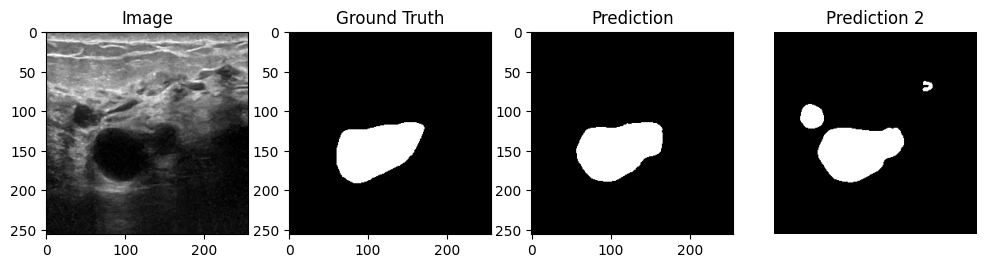

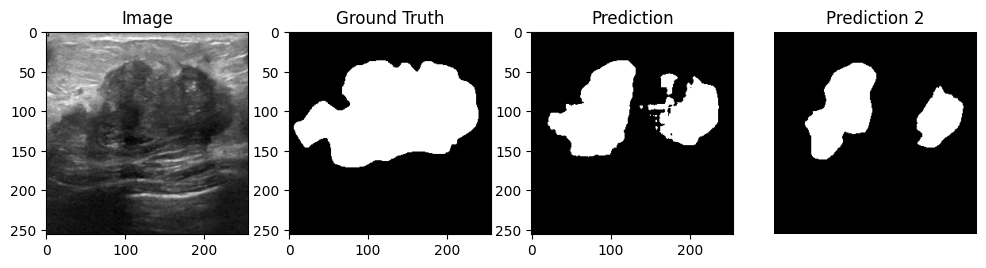

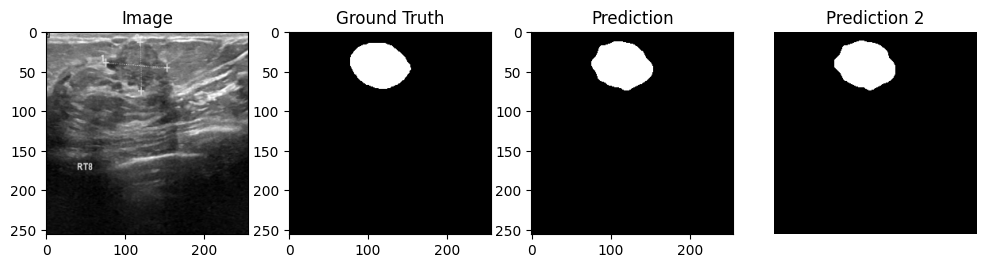

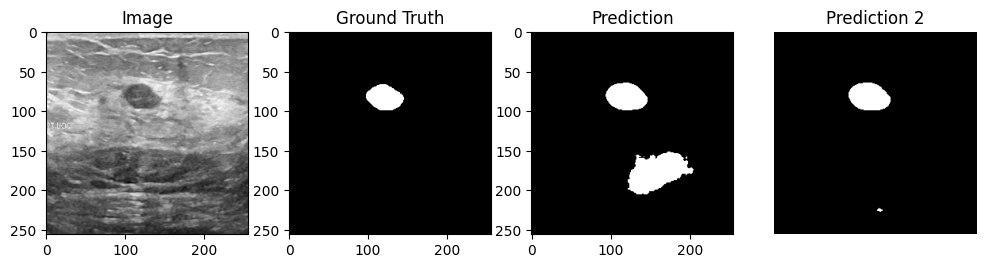

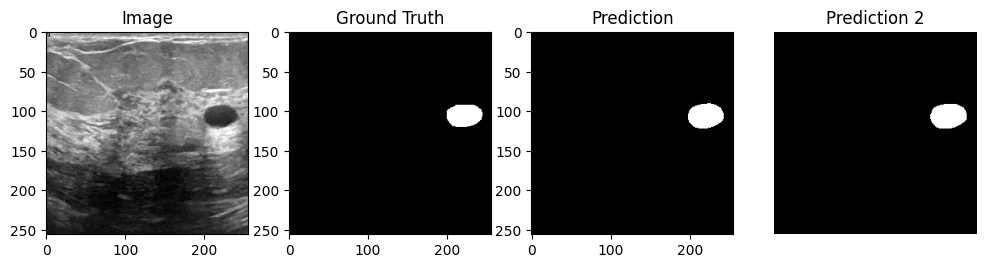

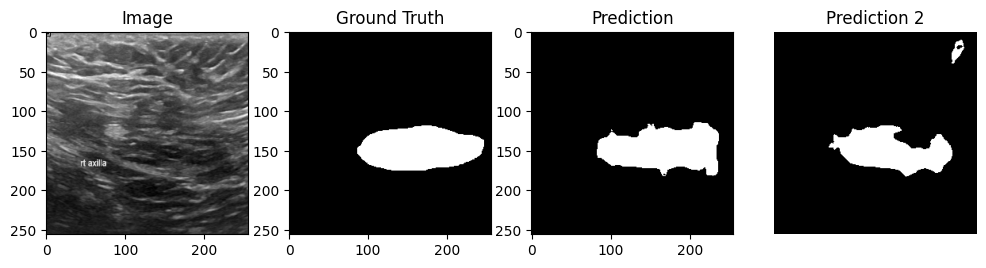

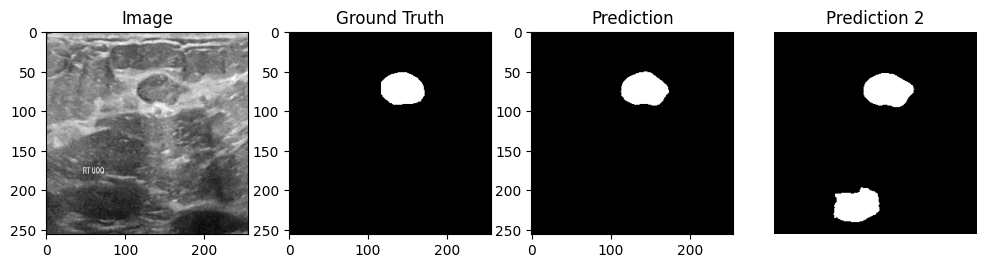

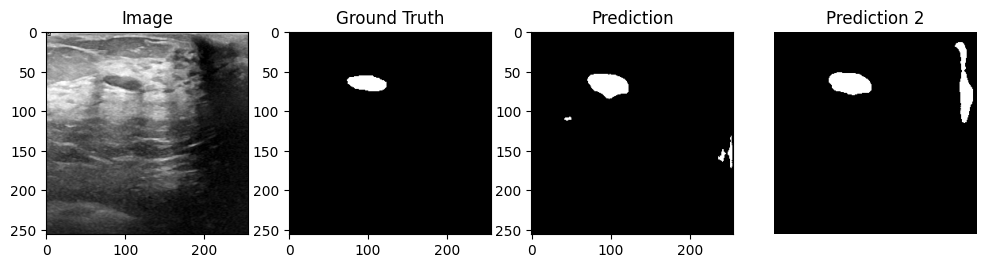

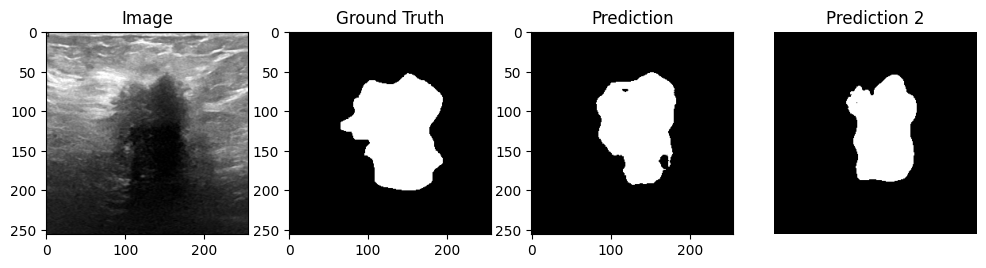

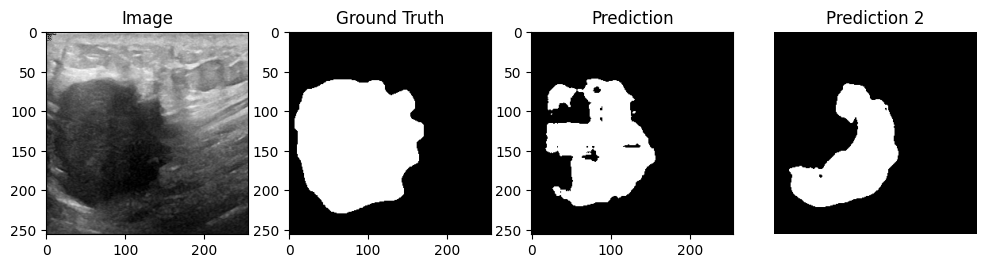

In [12]:
import models

def compare_models(model1_name, model2_name, count):
    model1 = models.__dict__[model1_name](n_channels=1, n_classes=1).cuda()
    model2 = models.__dict__[model2_name](n_channels=1, n_classes=1).cuda()

    model1.load_state_dict(torch.load(f'model_files/{model1_name}/model.pth'))
    model2.load_state_dict(torch.load(f'model_files/{model2_name}/model.pth'))

    for _ in range(count):

        idx = random.randint(0, len(image_paths) - 1)

        image, mask = load_tensor(image_paths[idx], mask_paths[idx])
        mask = mask.unsqueeze(0)
        image = image.unsqueeze(0)
        model1_prediction = model1(image)
        model2_prediction = model2(image)
        compare_prediction(image, mask, model1_prediction, model2_prediction)

compare_models('UNet', 'MR_UNet', 10)

In [4]:
# import the file "test_log.csv" and for a given name and size, print the mean dice score, standard deviation, mean iou and standard deviation
import pandas as pd

def print_stats(name, size):
    path = f"/home/cse/Documents/g1/test_log.csv"
    log = pd.read_csv(path)
    log = log[log['Image Size'] == size]
    log = log[log['Name'] == name]
    print(f"Model: {name}, Input Size: {size} x {size}")
    print(f"Dice: {log['Test Dice'].mean()} +- {log['Test Dice'].std()}")
    print(f"IoU: {log['Test IoU'].mean()} +- {log['Test IoU'].std()}")
    print(f"Parameters: {log['Parameters'].mean() / 1e6}M")

    print()

print_stats('UNet', 256)
print_stats('Wavelet_UNet', 256)
# print_stats('Wavelet_UNet_All', 256)
print_stats('MR_UNet', 256)
print_stats('UNet_Bilinear', 256)

Model: UNet, Input Size: 256 x 256
Dice: 0.7626773906688149 +- 0.027439253103051543
IoU: 0.6213523992236241 +- 0.03452731746525473
Parameters: 31.036481M

Model: Wavelet_UNet, Input Size: 256 x 256
Dice: 0.7491755772021925 +- 0.023514948868569103
IoU: 0.6071046252933096 +- 0.0318488756902315
Parameters: 17.261825M

Model: MR_UNet, Input Size: 256 x 256
Dice: 0.7791275804443087 +- 0.026617340469162205
IoU: 0.6420116263034301 +- 0.035126201189761445
Parameters: 81.204161M

Model: UNet_Bilinear, Input Size: 256 x 256
Dice: 0.765546302593622 +- 0.028404409183147045
IoU: 0.6258804272106205 +- 0.03601225291697522
Parameters: 17.261825M



[[[[-0.873342   -0.745879   -0.8005541  ... -0.46814743 -0.45523423
    -0.64241135]
   [-0.37147388 -0.93328047 -1.0467819  ... -0.40513194 -0.75163865
    -0.7992427 ]
   [-0.06476322 -1.0151033  -0.8942865  ... -0.21033497 -0.71679926
    -0.69596237]
   ...
   [-0.2036886  -0.4438827  -0.33071682 ... -0.3575259  -0.4386892
    -0.16019177]
   [-0.20093691 -0.486179   -0.38174865 ... -0.44656667 -0.46173579
    -0.2011075 ]
   [-0.11751268 -0.2758983  -0.2879812  ... -0.47633383 -0.5477988
    -0.28586888]]]]


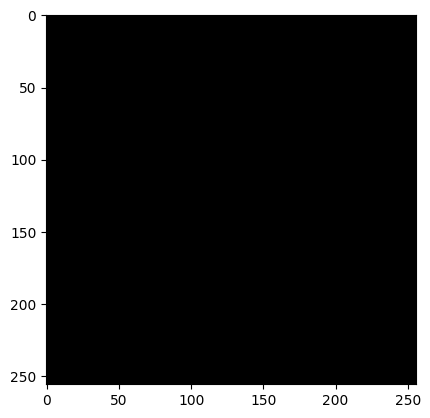

In [14]:
import models
from utils import load_tensor
import torch
import numpy as np
import matplotlib.pyplot as plt

model = models.UNet3Plus(n_channels=1, n_classes=1).cuda()
image = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
mask = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (1)_mask.png'
image, mask = load_tensor(image, mask)
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
# model.load_state_dict(torch.load('model_files/UNet2Plus/model.pth'))
model.eval()
model_prediction = model(image)
# convert model_prediction to a numpy array
model_prediction = model_prediction.cpu().detach().numpy()

print(model_prediction)
plt.imshow(model_prediction[0, 0, :, :], cmap='gray', vmin=0, vmax=1)